<a href="https://colab.research.google.com/github/gustafarsoares23/Tech-Challenge-4/blob/main/Tech_Challenge_4_Machine_Learning_Pre%C3%A7o_do_Petr%C3%B3leo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prevendo valores do Preço por Barril do Petróleo bruto Brent (FOB)**

# Introdução  
negritoNeste projeto, desenvolveremos uma solução para previsão do preço do petróleo Brent utilizando técnicas de Machine Learning. O desafio consiste em criar um modelo capaz de prever os preços diários, além de construir um dashboard interativo para apresentar os resultados e insights obtidos.  

O preço do petróleo Brent é influenciado por diversos fatores, como eventos geopolíticos, crises econômicas e a demanda global por energia. A análise desses dados históricos possibilita identificar padrões e realizar previsões que auxiliam na tomada de decisão.  

Para isso, utilizaremos dados históricos obtidos do site do IPEA, contendo colunas de data e preço (em dólares) no período de **2014 a 2025**. O projeto será desenvolvido em Python, utilizando bibliotecas como Pandas, NumPy, Scikit-learn e Streamlit para o desenvolvimento do modelo e visualização interativa.negrito







## Objetivos  
O principal objetivo deste projeto é desenvolver um modelo de Machine Learning para prever o preço do petróleo Brent de forma diária. Para isso, serão realizadas as seguintes etapas:  

- Análise exploratória dos dados históricos para identificar padrões e tendências.  
- Desenvolvimento de um dashboard interativo para visualização dos resultados e geração de insights.  
- Construção de um modelo de previsão utilizando técnicas de séries temporais.  
- Implementação do modelo em um MVP utilizando o Streamlit para disponibilização online.  
- Avaliação da performance do modelo e elaboração de um plano de deploy em produção.  


## **Sobre o dataset**

## Dataset  
O conjunto de dados utilizado neste projeto foi obtido a partir do site do IPEA (Instituto de Pesquisa Econômica Aplicada), utilizando a série histórica dos preços do petróleo Brent.  

Os dados foram filtrados para o período de **2014 a 2025**, abrangendo uma série temporal de aproximadamente 11 anos. Esta escolha se justifica pela relevância dos eventos econômicos e geopolíticos ocorridos neste intervalo, que impactaram significativamente os preços do petróleo.  

O dataset contém duas colunas principais:  
- **Data:** Representa o dia específico da cotação.  
- **Preço:** Valor do barril de petróleo Brent em dólares (USD).  

Antes da modelagem, realizamos o pré-processamento para corrigir valores ausentes, padronizar o formato das datas e garantir a consistência dos preços.  

Link para acessar os dados de Preço: http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view

### Importando as Bibliotecas

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

### Construindo o Dataset

#### Importando e checando os dados

In [31]:
df = pd.read_csv('ipeadata.csv', sep=';', encoding='latin1')

In [32]:
# Verificando os dados
df.head()

,ï»¿Data,Preco
0,02/05/2025,"61,57"
1,01/05/2025,"62,37"
2,30/04/2025,"63,37"
3,29/04/2025,"64,04"
4,28/04/2025,"66,13"


In [33]:
df.tail()

,ï»¿Data,Preco
3384,07/01/2014,"106,57"
3385,06/01/2014,"107,94"
3386,04/01/2014,"109,95"
3387,03/01/2014,"110,47"
3388,02/01/2014,"107,94"


#### Mudando o nome das colunas

In [34]:
# Renomeando as colunas e padronizando para facilitar os códigos:
df.columns = df.columns.str.strip().str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [35]:
df.rename(columns={'idata': 'data'}, inplace=True)

In [36]:
# Verificando os dados
df.head()

,data,preco
0,02/05/2025,"61,57"
1,01/05/2025,"62,37"
2,30/04/2025,"63,37"
3,29/04/2025,"64,04"
4,28/04/2025,"66,13"


#### Transformando a coluna data em Datetime

In [37]:
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')

In [38]:
# Verificando os dados
df.head()

,data,preco
0,2025-05-02,"61,57"
1,2025-05-01,"62,37"
2,2025-04-30,"63,37"
3,2025-04-29,"64,04"
4,2025-04-28,"66,13"


#### Transformando a coluna preco em int

In [39]:
# Substituindo a vírgula por ponto
df['preco'] = df['preco'].str.replace(',', '.')

In [40]:
# verificando a substituição
df.head()

,data,preco
0,2025-05-02,61.57
1,2025-05-01,62.37
2,2025-04-30,63.37
3,2025-04-29,64.04
4,2025-04-28,66.13


In [41]:
# transformando preço em numerico
df['preco'] = pd.to_numeric(df['preco'])

In [42]:
# verificando se as colunas estão corretas
print(df.dtypes)

data     datetime64[ns]
preco           float64
dtype: object


#### Colocando a coluna data como index

In [43]:
df.set_index('data', inplace=True)

In [45]:
# Verificando os dados
df.head()

,preco
data,
2025-05-02,61.57
2025-05-01,62.37
2025-04-30,63.37
2025-04-29,64.04
2025-04-28,66.13


In [46]:
#type(dados) #heck para ver se realmente a coluna index

#### Visualizando os valores de fechamento das ações

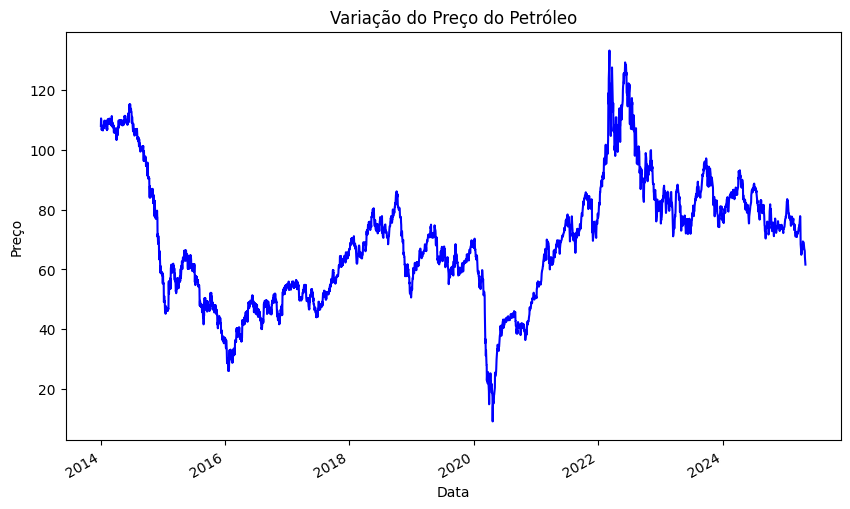

In [47]:
df['preco'].plot(figsize=(10, 6), linestyle='-', color='b')

# Adicionando rótulos e título ao gráfico
plt.title('Variação do Preço do Petróleo')
plt.xlabel('Data')
plt.ylabel('Preço')

# Exibindo o gráfico
plt.show()

## Decomposição para Análise da série temporal

Utilizaremos a biblioteca **Statsmodels** para decompor a série temporal em três componentes principais:  

- **Tendência:** Representa a direção geral da série ao longo do tempo, indicando movimentos ascendentes ou descendentes.  
- **Sazonalidade:** Corresponde a padrões que se repetem em intervalos específicos, refletindo comportamentos cíclicos.  
- **Ruído (Resíduo):** É a variação não explicada pela tendência e sazonalidade, capturando flutuações imprevisíveis.  

### Importância da Decomposição  
A decomposição da série temporal é fundamental para entender melhor os dados e para a escolha do modelo preditivo mais adequado. Ela possibilita:  

- **Previsões de Longo Prazo:** Ao identificar a tendência, podemos estimar o comportamento futuro.  
- **Previsões de Curto Prazo:** A identificação da sazonalidade permite capturar variações periódicas.  
- **Aprimoramento do Modelo:** A análise dos resíduos ajuda a identificar padrões não capturados, permitindo ajustes mais precisos.  

### Série Aditiva ou Multiplicativa  
A decomposição também indica se a série é:  
- **Aditiva:** A magnitude da sazonalidade e da tendência permanece constante ao longo do tempo.  
- **Multiplicativa:** A magnitude das variações cresce ou diminui proporcionalmente ao nível da série.  

Com a decomposição, conseguimos compreender os elementos estruturais da série e aprimorar as previsões com base nas características identificadas.  


### Decompondo todo dataset em serie, tendência, sazonalidade e ruído

In [48]:
resultados = seasonal_decompose(df, model='multiplicative', period=5) # Period = sazonaliade. Como temos dados de segunda a sexta, então temos 5, referentes aos 5 dias

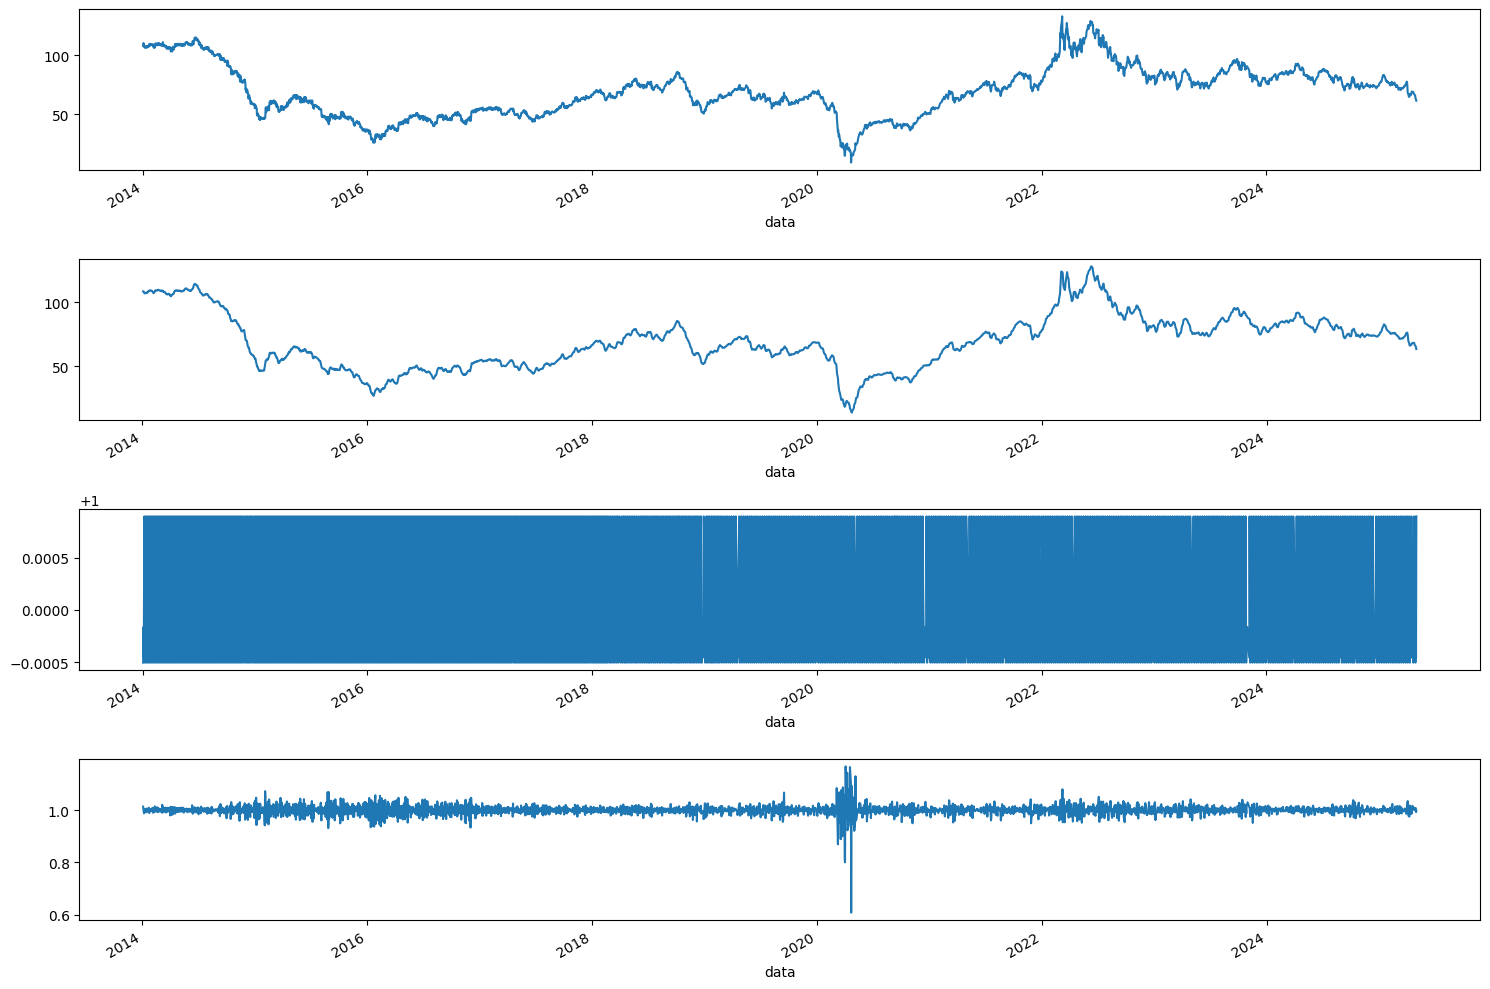

In [49]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1) # Serie dos dados
resultados.trend.plot(ax=ax2) # tendência dos dados
resultados.seasonal.plot(ax=ax3) # sazonalidade
resultados.resid.plot(ax=ax4) # resíduos

plt.tight_layout()

### Decompondo **5 anos** do dataset em serie, tendência, sazonalidade e ruído

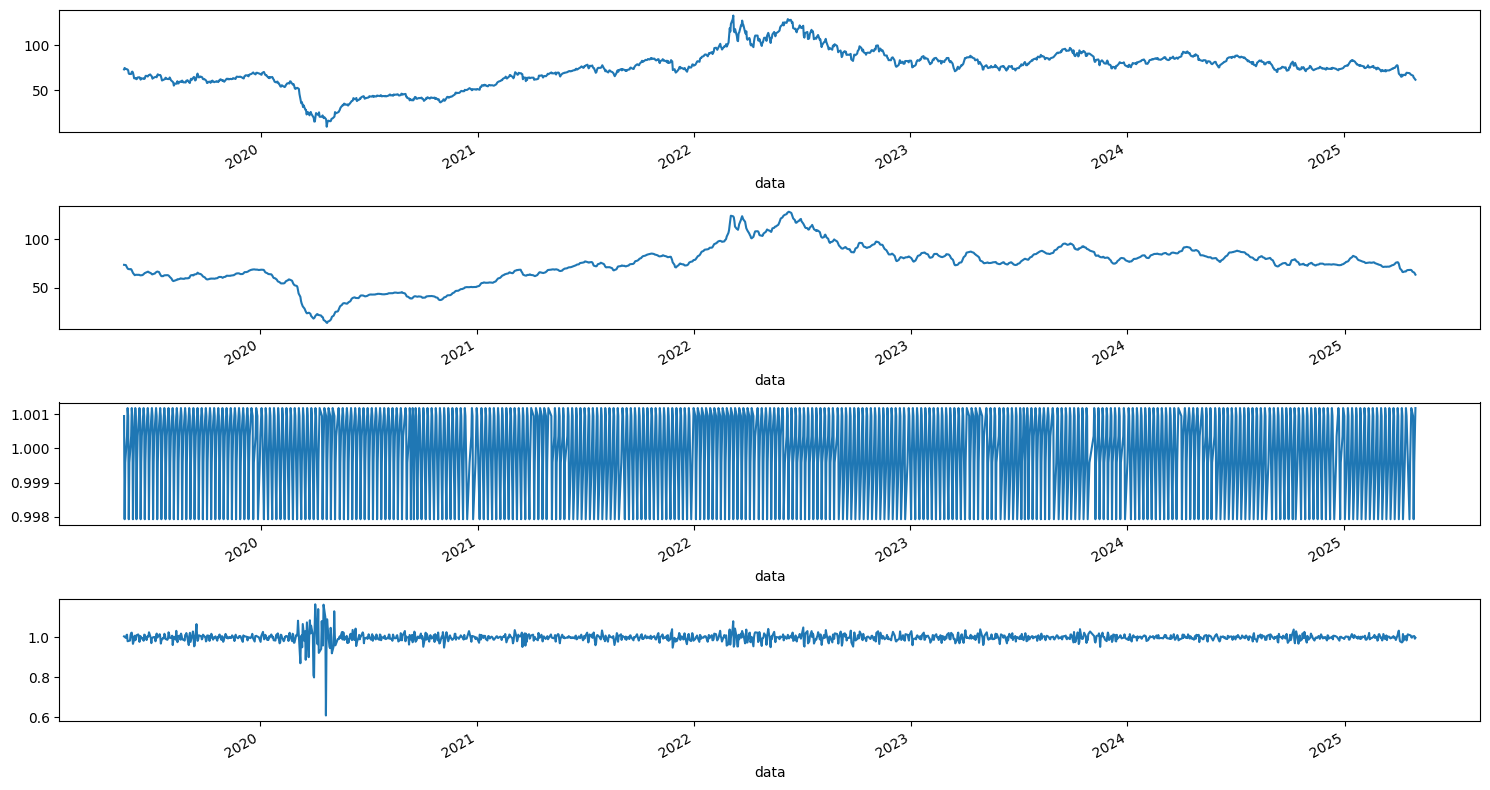

In [50]:
df_5_anos = df.loc['2019-05-15':]
seasonplot = seasonal_decompose(df_5_anos, model='multiplicative', period=5)  # decompondo a série temporal

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # série real
seasonplot.trend.plot(ax=ax2)  # tendência
seasonplot.seasonal.plot(ax=ax3)  # sazonalidade
seasonplot.resid.plot(ax=ax4)  # resíduos
plt.tight_layout()
plt.show()

## **Testando Modelos de Machine Learning Clássicos**

### **Média Móvel**

A média móvel é uma técnica estatística amplamente utilizada na análise de séries temporais e dados financeiros. Seu principal objetivo é suavizar flutuações aleatórias, permitindo identificar tendências de forma mais clara ao longo do tempo.  

A ideia central da média móvel é calcular, para cada ponto da série temporal, a média dos valores dos pontos vizinhos em um intervalo definido. Isso reduz a variabilidade dos dados e destaca a trajetória da tendência.  

### Implementação  
Vamos utilizar a técnica de média móvel com dois períodos distintos:  
- **N = 10 dias:** Para captar tendências de curto prazo.  
- **N = 20 dias:** Para identificar tendências mais estáveis ao longo do tempo.  

Essas médias móveis nos ajudarão a visualizar a evolução dos preços do petróleo Brent, reduzindo o impacto de variações pontuais e facilitando a análise de tendências.  

Vamos utilizar esta técnica para um N de 10 e de 20 dias.

#### Criando a base

In [51]:
dados_MA = df.copy()  # criando uma cópia do DataFrame original

# Adicionando colunas ao DataFrame copiado
dados_MA['MA_window_10'] = dados_MA['preco'].rolling(10).mean().shift()  # média móvel em 10 dias
dados_MA['MA_window_20'] = dados_MA['preco'].rolling(20).mean().shift()  # média móvel em 20 dias

#Rolling = especifica o número de observações usadas para calcular a estatística
#shift = utilizado para deslocar o índice de DataFrame por um número especificado de períodos com uma freqüência de tempo

In [52]:
dados_MA.head(20)

,preco,MA_window_10,MA_window_20
data,,,
2025-05-02,61.57,NaN,NaN
2025-05-01,62.37,NaN,NaN
2025-04-30,63.37,NaN,NaN
2025-04-29,64.04,NaN,NaN
2025-04-28,66.13,NaN,NaN
2025-04-25,66.99,NaN,NaN
2025-04-24,67.50,NaN,NaN
2025-04-23,68.26,NaN,NaN
2025-04-22,68.93,NaN,NaN


#### Vizualizando o Resultado

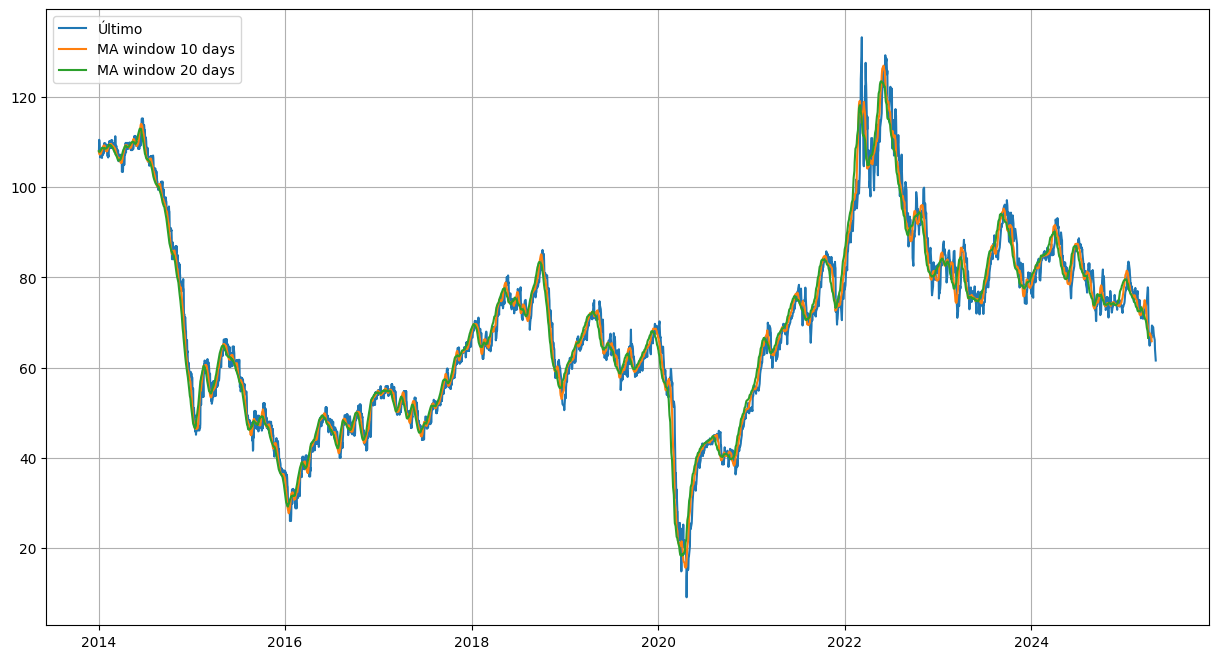

In [53]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.plot(dados_MA['preco'], label='Último')
plt.plot(dados_MA['MA_window_10'], label='MA window 10 days')
plt.plot(dados_MA['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

#### Visualizando os dados mais recentes: últimos 365 dias

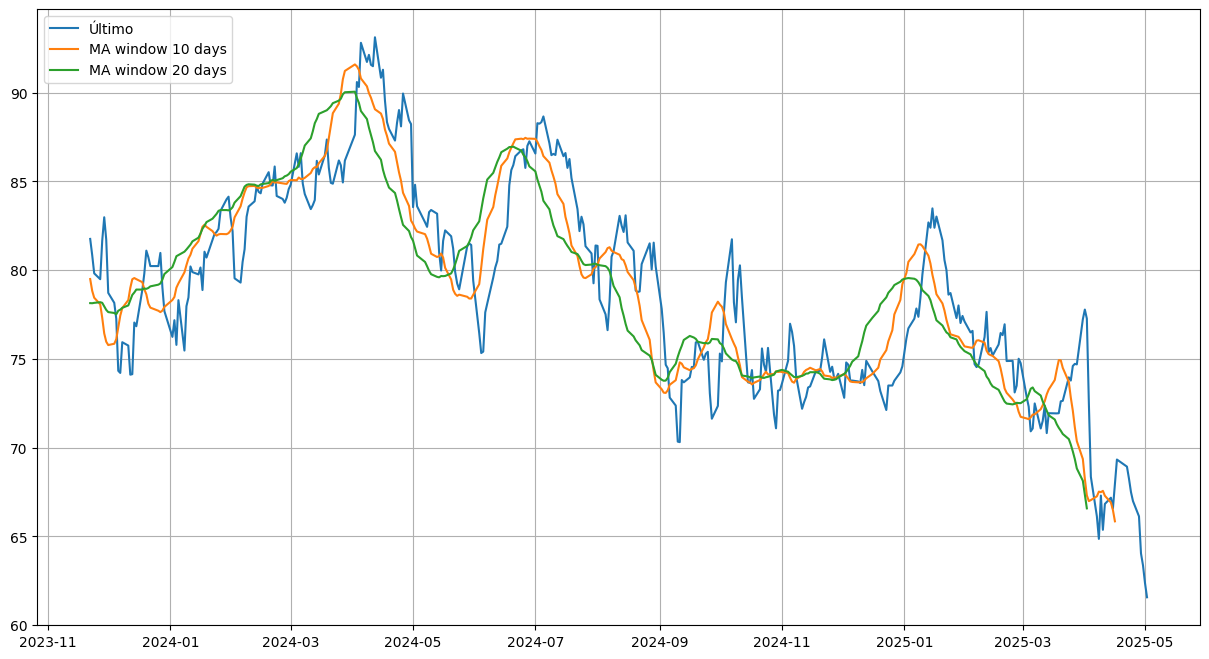

In [54]:
import matplotlib.pyplot as plt

# Ordenando o DataFrame pela coluna de datas
dados_MA = dados_MA.sort_index(ascending=True)

# Pegando os últimos 300 dias a partir da data mais recente
df_precos_300_dias = dados_MA.tail(365)

plt.figure(figsize=(15, 8))
plt.grid(True)

plt.plot(df_precos_300_dias['preco'], label='Último')
plt.plot(df_precos_300_dias['MA_window_10'], label='MA window 10 days')
plt.plot(df_precos_300_dias['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

#### Prevendo os "N" dias com base na média móvel aritmética

In [55]:
dados_MA['MA_window_10_forward_10'] = np.nan #preechendo com NaN os valores da coluna de MA_window_10_forward_10

In [56]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]

In [57]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(dados_MA), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(dados_MA):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([dados_MA['preco'].iloc[window_close], dados_MA['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        dados_MA.iat[index + i, dados_MA.columns.get_loc('MA_window_10_forward_10')] = mean

#### Analisando o último ano em um gráfico, com as previsões

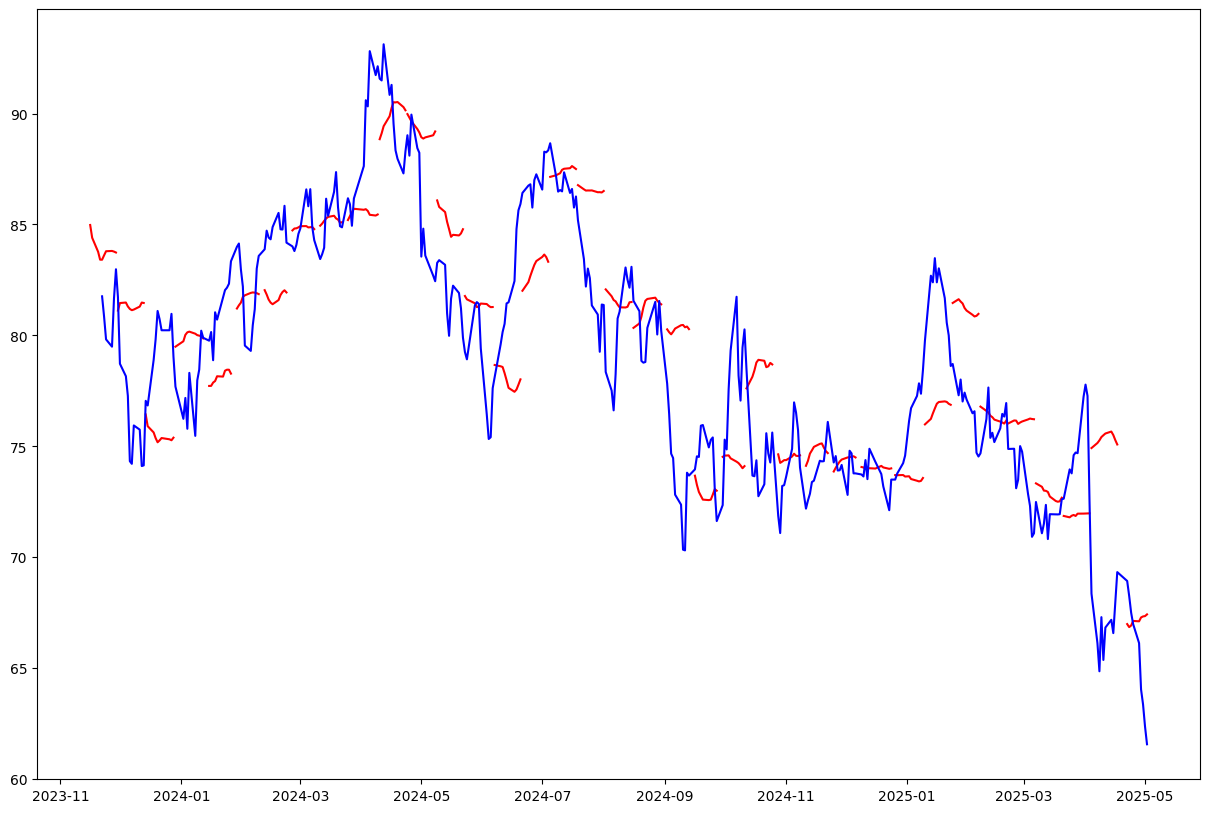

In [58]:
limit = 365

plt.figure(figsize = (15,10))

size = len(dados_MA)-limit - (len(dados_MA)-limit)%forward_days

for index in range(size, len(dados_MA), forward_days):
    plt.plot(dados_MA['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(dados_MA['preco'][-limit:], color='b', label='Close')
#plt.legend(loc='best')
plt.show()

O gráfico apresenta a série temporal dos preços do petróleo Brent (linha azul) e as previsões de 10 dias (linhas vermelhas) obtidas por meio da média móvel.

Cada reta vermelha representa uma previsão baseada nos 10 dias anteriores, resultando em intervalos distintos ao longo da série temporal, já que as previsões não se conectam diretamente.

Embora a média móvel seja amplamente utilizada para análise de séries temporais, ela tem limitações quando se trata de previsão de valores futuros com precisão. Neste caso, a abordagem de previsão de N dias à frente busca capturar tendências de curto prazo, mas nem sempre consegue acompanhar as variações reais do preço do petróleo.

Os resultados mostram que as previsões obtidas pela média móvel não são satisfatórias para modelar a série temporal do petróleo Brent. Isso ocorre porque o modelo não captura adequadamente as oscilações e mudanças bruscas de preço, comuns neste contexto.

Diante dessas limitações, vamos explorar outro modelo clássico mais adequado para lidar com séries temporais e variações abruptas: o ARIMA.

### Testando o modelo ARIMA

O modelo **ARIMA (AutoRegressive Integrated Moving Average)** é uma técnica amplamente utilizada para análise e previsão de séries temporais. Ele combina três componentes principais:  
- **AR (Auto-Regressivo):** Utiliza a relação linear entre os valores passados da série.  
- **I (Integração):** Transforma uma série não estacionária em estacionária.  
- **MA (Média Móvel):** Modela o erro como uma combinação linear dos erros passados.  

### Implementação  
Optamos por utilizar o modelo ARIMA devido à sua capacidade de capturar padrões lineares e componentes sazonais após a transformação da série em estacionária.  

Realizamos a otimização dos parâmetros (p, d, q) para encontrar a melhor combinação que minimize o erro de previsão.  

### Resultados  
Após o ajuste e a aplicação do modelo ARIMA, observamos que as previsões seguem mais de perto as variações da série temporal em comparação com a média móvel. O modelo conseguiu captar tanto as tendências quanto as oscilações de curto prazo de maneira mais consistente.  

Apesar da melhora em relação à média móvel, ainda existem desvios em períodos de grande variação no preço do petróleo, indicando que o modelo possui limitações para captar eventos inesperados ou mudanças bruscas na série.  

Diante disso, iremos explorar abordagens mais robustas, como redes neurais, para aprimorar as previsões.  

#### Plotando e analisando ACF e PCF

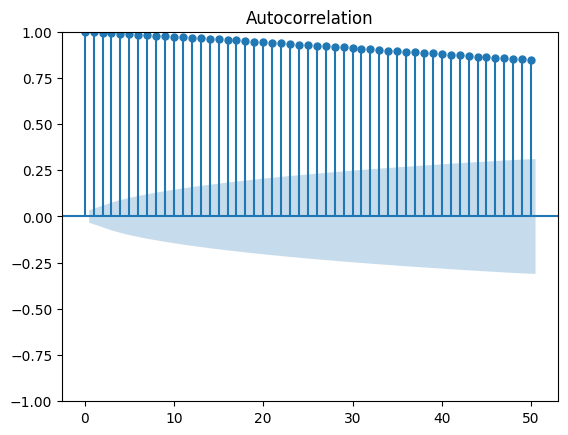

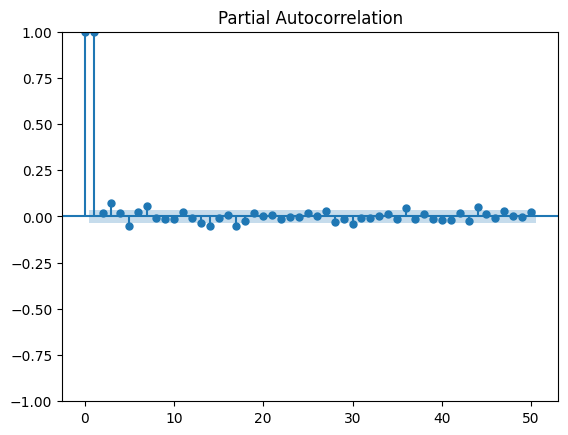

In [59]:
# Plotando a ACF
plot_acf(df['preco'], lags=50)

# Plotando a PACF
plot_pacf(df['preco'], lags=50)

plt.show()

O gráfico de Correlação Parcial Direta (PACF) revela que, após os primeiros 2 lags, a maioria dos lags subsequentes está dentro da faixa azul, indicando baixa significância estatística. Isso sugere que, após considerar os efeitos dos lags intermediários, os demais lags não contribuem significativamente para a autocorrelação parcial.

O PACF é essencial para identificar os atrasos específicos que têm influência direta no valor atual, ajudando na determinação da ordem de defasagem mais adequada para um modelo autoregressivo (AR).

Com base no gráfico, verificamos que a ordem de defasagem apropriada para essa série temporal é 2, pois os dois primeiros lags têm correlação significativa com os valores atuais. Isso é fundamental para a construção de um modelo AR mais preciso.

#### Analisando e plotando média movel e desvio padrão

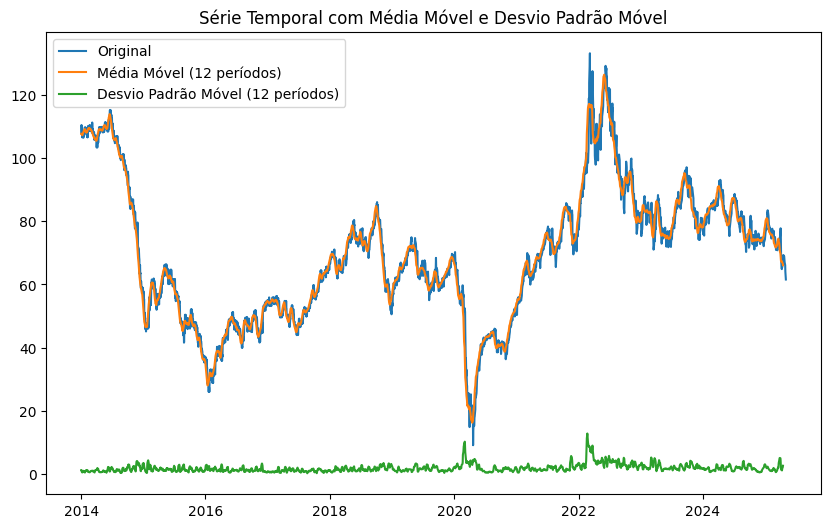

In [60]:
window_size = 12  # ajuste conforme necessário

# Calculando a média móvel e o desvio padrão
rolling_mean = df['preco'].rolling(window=window_size).mean()
rolling_std = df['preco'].rolling(window=window_size).std()

# Plotando a série temporal original, média móvel e desvio padrão
plt.figure(figsize=(10, 6))
plt.plot(df['preco'], label='Original')
plt.plot(rolling_mean, label=f'Média Móvel ({window_size} períodos)')
plt.plot(rolling_std, label=f'Desvio Padrão Móvel ({window_size} períodos)')

plt.title('Série Temporal com Média Móvel e Desvio Padrão Móvel')
plt.legend()
plt.show()


# Aplicando o Teste de Dickey-Fuller  

O **Teste de Dickey-Fuller Aumentado (ADF)** é utilizado para verificar a estacionariedade da série temporal, um requisito fundamental para a aplicação de alguns modelos preditivos, como o ARIMA.  

### Hipóteses do Teste ADF:  
- **H0 (Hipótese Nula):** A série temporal não é estacionária (possui raiz unitária).  
- **H1 (Hipótese Alternativa):** A série temporal é estacionária (não possui raiz unitária).  

### Interpretação dos Resultados:  
- **Estatística ADF:**  
  - Se a estatística ADF for menor que os valores críticos (nível de significância de 1%, 5% ou 10%), rejeitamos a hipótese nula, indicando que a série é estacionária.  
  - Quanto mais negativa for a estatística ADF, mais forte é a evidência contra a hipótese nula.  

- **Valor p (p-value):**  
  - Um valor p menor que um nível de significância (por exemplo, 0.05) sugere que a série é estacionária.  
  - Valores p altos indicam que a série não é estacionária, sugerindo a necessidade de diferenciação.  

### Estacionariedade na Série Temporal:  
A estacionariedade é essencial para garantir que a média e a variância permaneçam constantes ao longo do tempo, facilitando a modelagem e projeção dos dados. Em séries estacionárias, os padrões são mais consistentes em períodos específicos, embora isso também possa indicar falta de previsibilidade no longo prazo.  

Neste caso, os resultados obtidos indicaram que a série **não é estacionária** inicialmente, o que nos levou a aplicar transformações para garantir que os modelos possam realizar previsões com maior precisão.  


In [61]:
# Função para realizar o Teste de Dickey-Fuller e imprimir os resultados
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')

    print('Resultado do Teste de Dickey-Fuller:')
    print('Estatística do Teste:', result[0])
    print('Valor p:', result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if result[1] <= 0.05:
        print("\nResultado: A série é estacionária.")
    else:
        print("\nResultado: A série não é estacionária.")

# Aplicar o Teste de Dickey-Fuller na série temporal original
adf_test(df['preco'].dropna())

Resultado do Teste de Dickey-Fuller:
Estatística do Teste: -1.8540579318865038
Valor p: 0.35397250610939557
Valores Críticos:
   1%: -3.4322982894792395
   5%: -2.8624008407391885
   10%: -2.5672282424116677

Resultado: A série não é estacionária.


O resultado do teste de Dickey-Fuller indica que a série não é estacionária. Isso pode ser verificado pelo valor p de aproximadamente 0,354, que é maior que 0,05. Além disso, a estatística do teste (-1,854) não é menor que nenhum dos valores críticos apresentados (1%, 5% e 10%). Dessa forma, não podemos rejeitar a hipótese nula (H0), que sugere a presença de raiz unitária.

A ausência de estacionariedade é um desafio para a modelagem com o modelo ARIMA, pois ele pressupõe que a série seja estacionária para garantir previsões confiáveis. Portanto, será necessário aplicar transformações adicionais, como diferenciação, para estabilizar a média da série e possibilitar sua modelagem.

#### Transformando em estacionária

In [62]:
df.head() # check para ver se nada se alterou no dataset final

,preco
data,
2025-05-02,61.57
2025-05-01,62.37
2025-04-30,63.37
2025-04-29,64.04
2025-04-28,66.13


##### 1º teste: subtrair os dados transformados pelo log pela média móvel.
Objetivo  
O objetivo desta transformação é **estabilizar a variância** da série temporal, especialmente quando a amplitude dos dados varia ao longo do tempo.  

Método  
Vamos aplicar o **logaritmo** aos dados para realizar a transformação, buscando remover o componente de tendência. Em seguida, subtrairemos a **média móvel** dos valores logaritmizados, para suavizar as oscilações e obter uma série mais estável.  

Interpretação  
Se a transformação for bem-sucedida, obteremos curvas mais planas, próximas ao eixo x, e médias contínuas após a aplicação do logaritmo. Isso indicará que a transformação conseguiu estabilizar a série, reduzindo a influência de picos e vales abruptos.  

Ao observar os gráficos resultantes, esperamos identificar uma série temporal mais homogênea, o que facilitará a modelagem preditiva.  

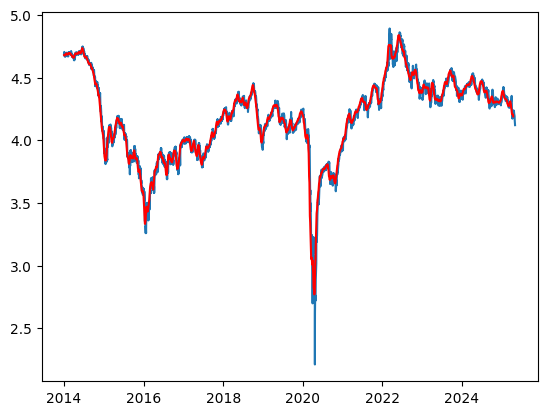

In [63]:
#Estimating trend
dados_log = np.log(df) #Transformação logarítma

# Calculando a média móvel
ma = dados_log.rolling(window=12).mean()
mstd = dados_log.rolling(window=12).std()

# Plotando
plt.plot(dados_log)
plt.plot(ma, color='red')

In [64]:
dados_log_minus_ma = dados_log - ma
dados_log_minus_ma.head(12)

#Remove NAN values
dados_log_minus_ma.dropna(inplace=True)

In [65]:
# Função para testar a estacionariedade da série transformada
def test_stationarity(timeseries):

    # Determinar estatísticas contínuas
    ma = timeseries.rolling(window=12).mean()
    mstd = timeseries.rolling(window=12).std()

    # Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(ma, color='red', label='Rolling Mean')
    std = plt.plot(mstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['preco'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    # Tomar uma decisão com base no valor p
    if dfoutput['p-value'] <= 0.05:
        print("\nResultado: A série é estacionária.")
    else:
        print("\nResultado: A série não é estacionária.")


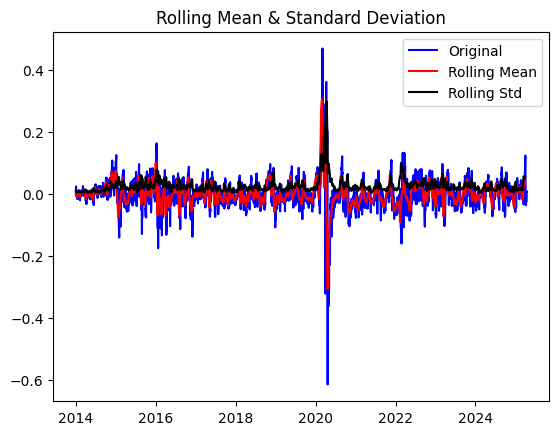

Results of Dickey Fuller Test:
Test Statistic                -9.449214e+00
p-value                        4.665287e-16
#Lags Used                     2.700000e+01
Number of Observations Used    3.350000e+03
Critical Value (1%)           -3.432304e+00
Critical Value (5%)           -2.862403e+00
Critical Value (10%)          -2.567229e+00
dtype: float64

Resultado: A série é estacionária.


In [66]:
test_stationarity(dados_log_minus_ma)

Aqui já conseguimos transformar a serie em estacionária, mas vamos testar outros recursos, para torná-la mais estacionária ainda:

##### 2º teste : Decaimento exponencial.
Objetivo  
O objetivo desta transformação é **remover a tendência** da série temporal, tornando-a mais estacionária e adequada para modelagem preditiva.  

Método  
O decaimento exponencial utiliza uma **média exponencial ponderada** para suavizar os dados, atribuindo **maior peso às observações mais recentes** e **menor peso às observações mais antigas**. Dessa forma, as mudanças recentes têm um impacto maior na série ajustada.  

Interpretação  
Essa abordagem é especialmente útil quando há uma tendência forte nos dados que precisa ser suavizada. Ao aplicar o decaimento exponencial, esperamos obter uma série com variações mais equilibradas ao longo do tempo, mantendo a influência das observações mais atuais.  

Se a transformação for eficaz, observaremos uma série menos inclinada e com oscilações mais homogêneas, facilitando o uso de modelos autoregressivos, como o ARIMA.  


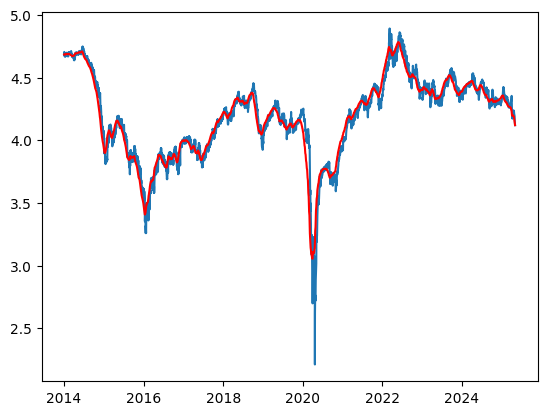

In [67]:
dados_log_exponential_decay = dados_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(dados_log)
plt.plot(dados_log_exponential_decay, color='red')

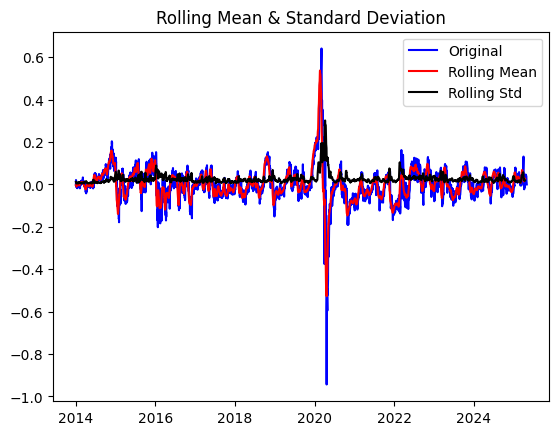

Results of Dickey Fuller Test:
Test Statistic                -8.542821e+00
p-value                        9.679457e-14
#Lags Used                     2.700000e+01
Number of Observations Used    3.361000e+03
Critical Value (1%)           -3.432297e+00
Critical Value (5%)           -2.862400e+00
Critical Value (10%)          -2.567228e+00
dtype: float64

Resultado: A série é estacionária.


In [68]:
# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
dados_log_minus_dados_log_exponential_decay = dados_log - dados_log_exponential_decay
test_stationarity(dados_log_minus_dados_log_exponential_decay)

Não iremos utilizar o decaimento exponencial, pois ficou menos estacionário que subtrair os dados transformados pelo log pela média móvel. Mas ainda há um teste a ser feito:

##### 3º teste : Diferenciação
Objetivo  
O objetivo da diferenciação é **remover a tendência** da série temporal, tornando-a mais estacionária e facilitando a aplicação de modelos preditivos que exigem estacionariedade, como o ARIMA.  

Método  
A técnica consiste em calcular a **diferença entre valores consecutivos** da série temporal. Isso reduz o impacto de tendências de longo prazo e destaca variações locais, ajudando a estabilizar a média da série.  

Interpretação  
Se a diferenciação for bem-sucedida, a série resultante apresentará uma **média constante ao longo do tempo**, com as flutuações se concentrando em torno de zero. Isso indica que a série está estacionária, o que é fundamental para obter previsões mais precisas com modelos autoregressivos.  

Vamos aplicar a primeira diferenciação e verificar os resultados, analisando se a série permanece com variância constante e ausência de tendência.  


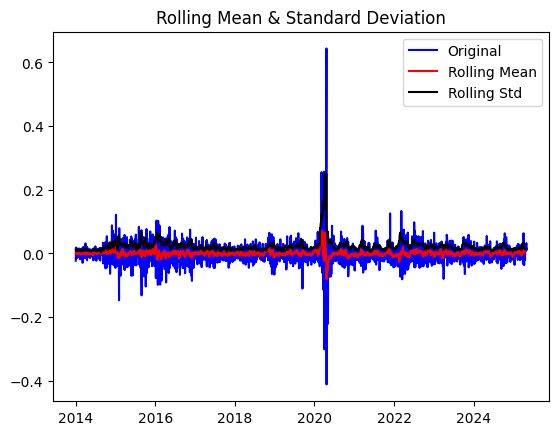

Results of Dickey Fuller Test:
Test Statistic                -9.637988e+00
p-value                        1.547969e-16
#Lags Used                     2.600000e+01
Number of Observations Used    3.361000e+03
Critical Value (1%)           -3.432297e+00
Critical Value (5%)           -2.862400e+00
Critical Value (10%)          -2.567228e+00
dtype: float64

Resultado: A série é estacionária.


In [69]:
dados_log_minus_DiffShifting = dados_log - dados_log.shift() #diferença entre o valor anterior e o atual
dados_log_minus_DiffShifting.dropna(inplace=True)
test_stationarity(dados_log_minus_DiffShifting)

Após aplicar a técnica de diferenciação, observamos que a **Rolling Mean** e a **Rolling STD** se aproximaram, indicando uma maior estabilidade da série. Isso sugere que a transformação foi eficaz em reduzir a tendência e estabilizar a variância ao longo do tempo.  

Além disso, ao analisarmos o gráfico resultante, podemos notar que o valor **p** zerou, comprovando fortemente a **estacionariedade** da série após a diferenciação.  

Diante desses resultados positivos, vamos continuar utilizando essa metodologia para construir o modelo **ARIMA**, garantindo previsões mais precisas e adequadas.  


#### Teste de correlação parcial
Para definir inicialmente os parâmetros do modelo **ARIMA**, precisamos estimar os valores de **P** (lags: valores autocorrelacionados) e **Q** (tamanho de uma janela).  

### Estratégia  
Vamos utilizar os gráficos de **ACF (Autocorrelation Function)** e **PACF (Partial Autocorrelation Function)** para determinar os valores iniciais desses parâmetros:  
- **Gráfico ACF:** Auxilia na definição do parâmetro **Q**, identificando o ponto em que a autocorrelação cai para zero.  
- **Gráfico PACF:** Ajuda na escolha do parâmetro **P**, identificando onde a autocorrelação parcial passa a ser insignificante.  

### Metodologia  
Vamos aplicar os plots ao nosso **dataset transformado pela diferenciação**, pois essa série já apresenta características de estacionariedade.  

O valor inicial de **P** e **Q** será determinado pelo ponto em que cada gráfico cruza o zero. Em alguns casos, ajustes finos podem ser necessários, já que pequenas variações nos parâmetros podem melhorar ou piorar o desempenho do modelo. Portanto, após definir os valores iniciais, testaremos variações positivas e negativas para encontrar a melhor configuração.  

Vamos visualizar os gráficos e identificar os pontos críticos para prosseguir com a modelagem do ARIMA.  


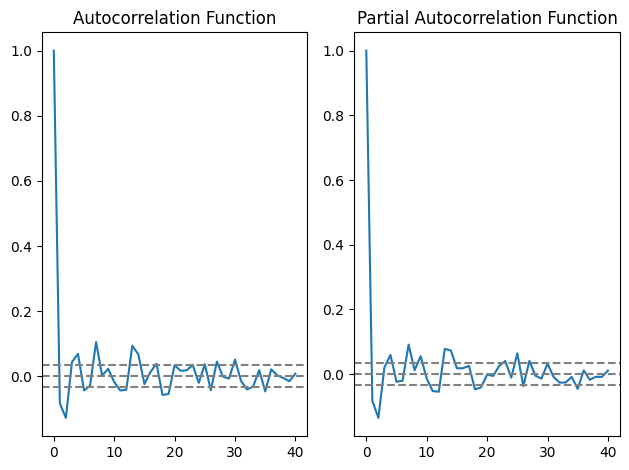

In [70]:
lag_acf = acf(dados_log_minus_DiffShifting, nlags=40)
lag_pacf = pacf(dados_log_minus_DiffShifting, nlags=40, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

Com base na análise dos gráficos, identificamos os seguintes valores para os parâmetros do modelo ARIMA:

Gráfico ACF: Observamos que a curva toca a linha y = 0,0 em x = 2, indicando que o valor de Q inicial será igual a 2.

Gráfico PACF: Da mesma forma, a curva toca a linha y = 0,0 em x = 2, o que determina que o valor de P inicial também será igual a 2.

Esses valores sugerem que tanto o componente autorregressivo (AR) quanto o componente de média móvel (MA) possuem defasagem igual a 2. Vamos testar variações desses parâmetros para garantir a configuração mais adequada do modelo ARIMA.


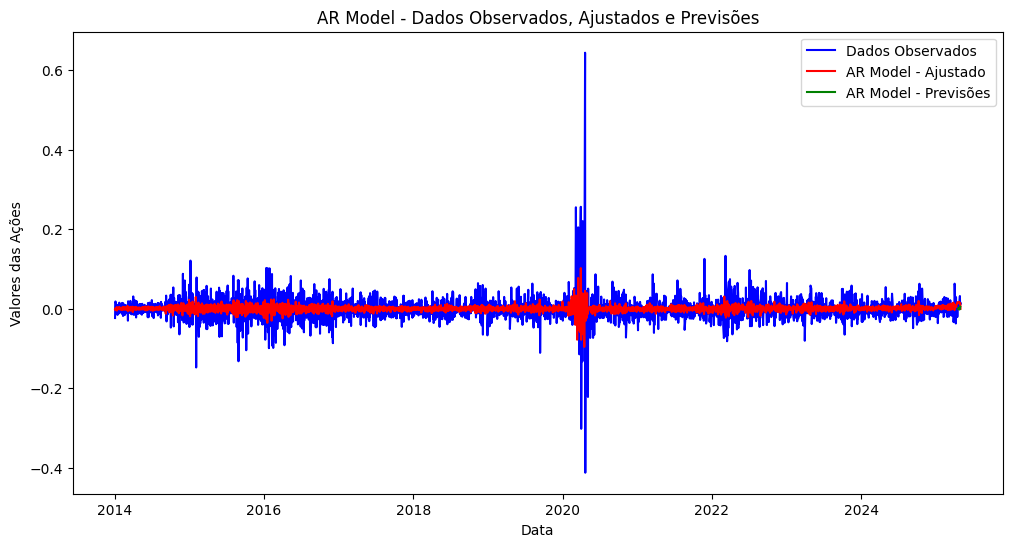

In [71]:
import warnings
warnings.filterwarnings("ignore")
# Configuração do modelo ARIMA
p = 2
d = 1
q = 24

# Ajuste do modelo ARIMA
model = ARIMA(dados_log_minus_DiffShifting['preco'], order=(p, d, q))
results_AR = model.fit()

# Previsões
forecast_steps = 10  # Ajuste conforme necessário
forecast = results_AR.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=dados_log_minus_DiffShifting.index.max(), periods=forecast_steps + 1, freq=dados_log_minus_DiffShifting.index.to_series().diff().mean())
# Aqui, o código define o número de passos futuros para prever (forecast_steps). O modelo ajustado é então usado para obter previsões (get_forecast) para os próximos passos especificados. O índice das previsões é gerado para refletir as datas futuras.

# Plotagem dos resultados
plt.figure(figsize=(12, 6))
plt.plot(dados_log_minus_DiffShifting.index, dados_log_minus_DiffShifting['preco'], color="blue", label='Dados Observados')
plt.plot(dados_log_minus_DiffShifting.index, results_AR.fittedvalues, color='red', label='AR Model - Ajustado')
plt.plot(forecast_index[1:], forecast.predicted_mean, color='green', label='AR Model - Previsões')
plt.title('AR Model - Dados Observados, Ajustados e Previsões')
plt.xlabel('Data')
plt.ylabel('Valores das Ações')
plt.legend()
plt.show()
# Aqui, os resultados são plotados. Os dados observados são mostrados em azul,
# as previsões ajustadas pelo modelo ARIMA são mostradas em vermelho e as previsões
# futuras são mostradas em verde. O gráfico visualiza como o modelo ARIMA se ajusta aos dados históricos e faz previsões para o futuro.

#### Validando o modelo com MAPE (Mean Absolute Percentage Error)

In [73]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = dados_log_minus_DiffShifting.index

# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = dados_log_minus_DiffShifting['preco'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(dados_log_minus_DiffShifting['preco'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 93.85%


O MAPE (Erro Percentual Absoluto Médio) é uma métrica amplamente utilizada para medir a precisão de previsões em séries temporais. Quanto menor o valor do MAPE, melhor é o desempenho do modelo em capturar os valores reais.

Resultados Obtidos
O MAPE calculado foi de 93,85%.

Em modelos ARIMA anteriores, os valores de MAPE variavam entre 400% e 550%, indicando uma precisão extremamente baixa.

Nesta versão atual com o modelo AR, conseguimos uma melhora significativa em relação aos modelos anteriores, com uma redução expressiva do MAPE para 93,85%.

Apesar da melhoria, o valor ainda é considerado alto, o que sugere que o modelo AR, mesmo após ajustes, não captura adequadamente as variações dos valores observados. Isso pode indicar que os dados possuem padrões mais complexos que não são adequadamente modelados apenas com componentes autorregressivos.

Vamos continuar testando outras abordagens para melhorar a precisão e reduzir o MAPE, buscando modelos que lidem melhor com a variabilidade da série.

## Testando com um modelo Robusto (Prophet)

O **Prophet** é uma biblioteca de código aberto desenvolvida pelo Facebook para a previsão de séries temporais. Sua abordagem baseia-se em uma **decomposição sazonal aditiva**, que divide os dados nos seguintes componentes:  
- **Tendência:** Captura a evolução dos valores ao longo do tempo.  
- **Sazonalidade Anual:** Identifica padrões que se repetem anualmente.  
- **Efeitos de Feriados:** Considera a influência de feriados específicos nos dados.  

### Vantagens do Prophet  
O modelo é projetado para lidar com dados que apresentam lacunas ou irregularidades, adaptando-se a diferentes tipos de padrões temporais. Além disso, ele permite a inclusão de **informações adicionais**, como feriados específicos, o que melhora a precisão das previsões.  

Outra vantagem do Prophet é sua interface amigável e a possibilidade de ajustar parâmetros, tornando-o acessível mesmo para quem não possui um conhecimento aprofundado em aprendizado de máquina.  

### Aplicações  
Devido à sua flexibilidade e robustez, o Prophet é amplamente utilizado em diversos contextos, como:  
- **Previsão de Demanda:** Identificação de picos sazonais em vendas.  
- **Análise Financeira:** Projeção de preços e tendências de mercado.  
- **Análise Climatológica:** Previsão de variáveis meteorológicas ao longo do ano.  

Vamos testar o modelo Prophet para avaliar se ele apresenta melhor desempenho na previsão dos preços do petróleo Brent em comparação aos modelos anteriores.  
ções, desde previsão de demanda até análise financeira e climatológica.

### Criando e Ajustando um novo dataset para o Prophet

### Criando lista de feriados nacionais brasileiros

In [74]:
df_copy = df.copy()

df_copy['ds'] = df_copy.index
df_copy['y'] = df_copy['preco']
df_copy = df_copy[['ds', 'y']].reset_index(drop=True)

df_copy.head()

,ds,y
0,2025-05-02,61.57
1,2025-05-01,62.37
2,2025-04-30,63.37
3,2025-04-29,64.04
4,2025-04-28,66.13


### Separando os dados em treino e teste

In [75]:
train_data = df_copy.sample(frac=0.7, random_state=0)
test_data = df_copy.drop(train_data.index)

print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (2372, 2)
testing data size : (1017, 2)


### Criando e plotando o modelo preditivo

In [76]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)

dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)

previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/eyjnbjzi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/9os435oh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32935', 'data', 'file=/tmp/tmpiw9vtasu/eyjnbjzi.json', 'init=/tmp/tmpiw9vtasu/9os435oh.json', 'output', 'file=/tmp/tmpiw9vtasu/prophet_model6o708cht/prophet_model-20250513024926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:49:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-03,111.370580,106.695151,125.041315,111.370580,111.370580,4.735173,4.735173,4.735173,8.905838,...,0.165120,0.165120,0.165120,-4.335784,-4.335784,-4.335784,0.0,0.0,0.0,116.105753
1,2014-01-06,111.005318,106.501381,124.014063,111.005318,111.005318,4.586885,4.586885,4.586885,8.905838,...,0.284481,0.284481,0.284481,-4.603434,-4.603434,-4.603434,0.0,0.0,0.0,115.592203
2,2014-01-07,110.883565,106.142057,124.545507,110.883565,110.883565,4.276288,4.276288,4.276288,8.905838,...,0.031553,0.031553,0.031553,-4.661103,-4.661103,-4.661103,0.0,0.0,0.0,115.159852
3,2014-01-08,110.761811,105.597974,124.230755,110.761811,110.761811,4.109894,4.109894,4.109894,8.905838,...,-0.094673,-0.094673,-0.094673,-4.701270,-4.701270,-4.701270,0.0,0.0,0.0,114.871705
4,2014-01-10,110.518303,106.047321,124.230051,110.518303,110.518303,4.343245,4.343245,4.343245,8.905838,...,0.165120,0.165120,0.165120,-4.727712,-4.727712,-4.727712,0.0,0.0,0.0,114.861548


In [77]:
# Gerar previsões para os próximos 30 dias
future = modelo.make_future_dataframe(periods=30, freq='D')
forecast = modelo.predict(future)

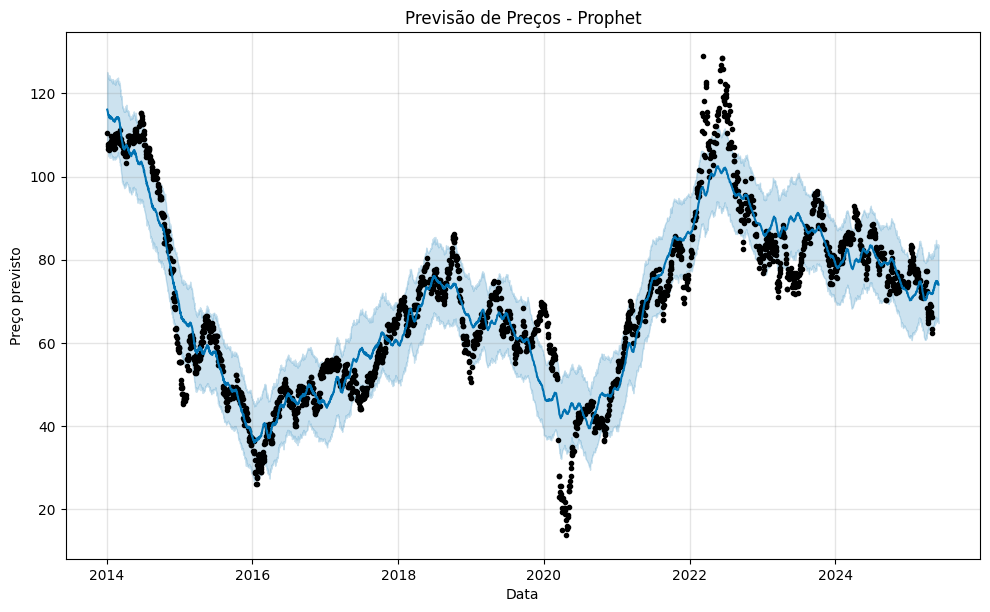

In [78]:
# Plotar os resultados
modelo.plot(forecast)
plt.title("Previsão de Preços - Prophet")
plt.xlabel("Data")
plt.ylabel("Preço previsto")
plt.show()

### Plotando com ploty

In [79]:
print(previsao.columns)
print(test_data.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
Index(['ds', 'y'], dtype='object')


In [80]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=previsao['ds'], y=previsao['yhat'], mode='lines', name='Previsão'))

fig.add_trace(go.Scatter(x=train_data['ds'], y=train_data['y'], mode='markers', marker=dict(color='red'), name='Dados Históricos'))

fig.update_layout(title='Previsão do Modelo - Prophet',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  showlegend=True,
                  xaxis=dict(rangeslider=dict(visible=True), type='date'))

fig.show()

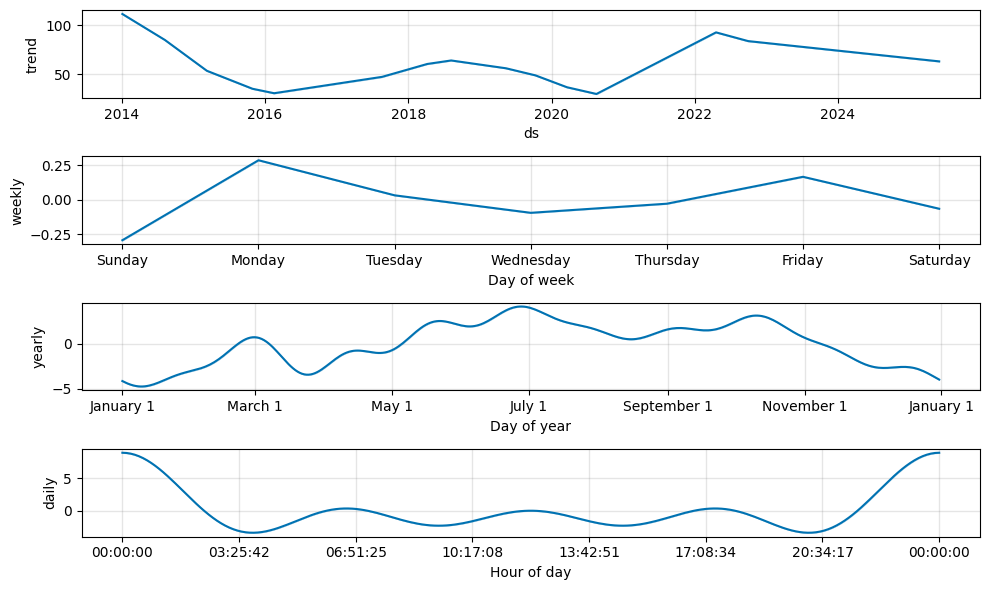

In [81]:
modelo.plot_components(previsao, figsize=(10,6));

### Adicionando Changepoints no modelo

O prophet permite adicionar pontos de mudanças na série temporal, o que nos permite identificar em quais datas ocorrem possíveis mudanças.

In [82]:
from prophet.plot import add_changepoints_to_plot

modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(train_data)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=30, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/cbk_lo9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/vkte1jy8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56020', 'data', 'file=/tmp/tmpiw9vtasu/cbk_lo9w.json', 'init=/tmp/tmpiw9vtasu/vkte1jy8.json', 'output', 'file=/tmp/tmpiw9vtasu/prophet_modelokzt2nyx/prophet_model-20250513025052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:50:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:50:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-03,122.544357,106.302130,128.699123,122.544357,122.544357,-4.421779,-4.421779,-4.421779,0.187963,0.187963,0.187963,-4.609742,-4.609742,-4.609742,0.0,0.0,0.0,118.122578
1,2014-01-06,122.121868,105.345720,128.217134,122.121868,122.121868,-4.658819,-4.658819,-4.658819,0.232931,0.232931,0.232931,-4.891750,-4.891750,-4.891750,0.0,0.0,0.0,117.463049
2,2014-01-07,121.981039,105.534309,129.118542,121.981039,121.981039,-4.879700,-4.879700,-4.879700,0.076208,0.076208,0.076208,-4.955908,-4.955908,-4.955908,0.0,0.0,0.0,117.101339
3,2014-01-08,121.840209,104.544313,128.627948,121.840209,121.840209,-5.021116,-5.021116,-5.021116,-0.017478,-0.017478,-0.017478,-5.003638,-5.003638,-5.003638,0.0,0.0,0.0,116.819093
4,2014-01-10,121.558550,105.435937,127.424012,121.558550,121.558550,-4.860709,-4.860709,-4.860709,0.187963,0.187963,0.187963,-5.048671,-5.048671,-5.048671,0.0,0.0,0.0,116.697841


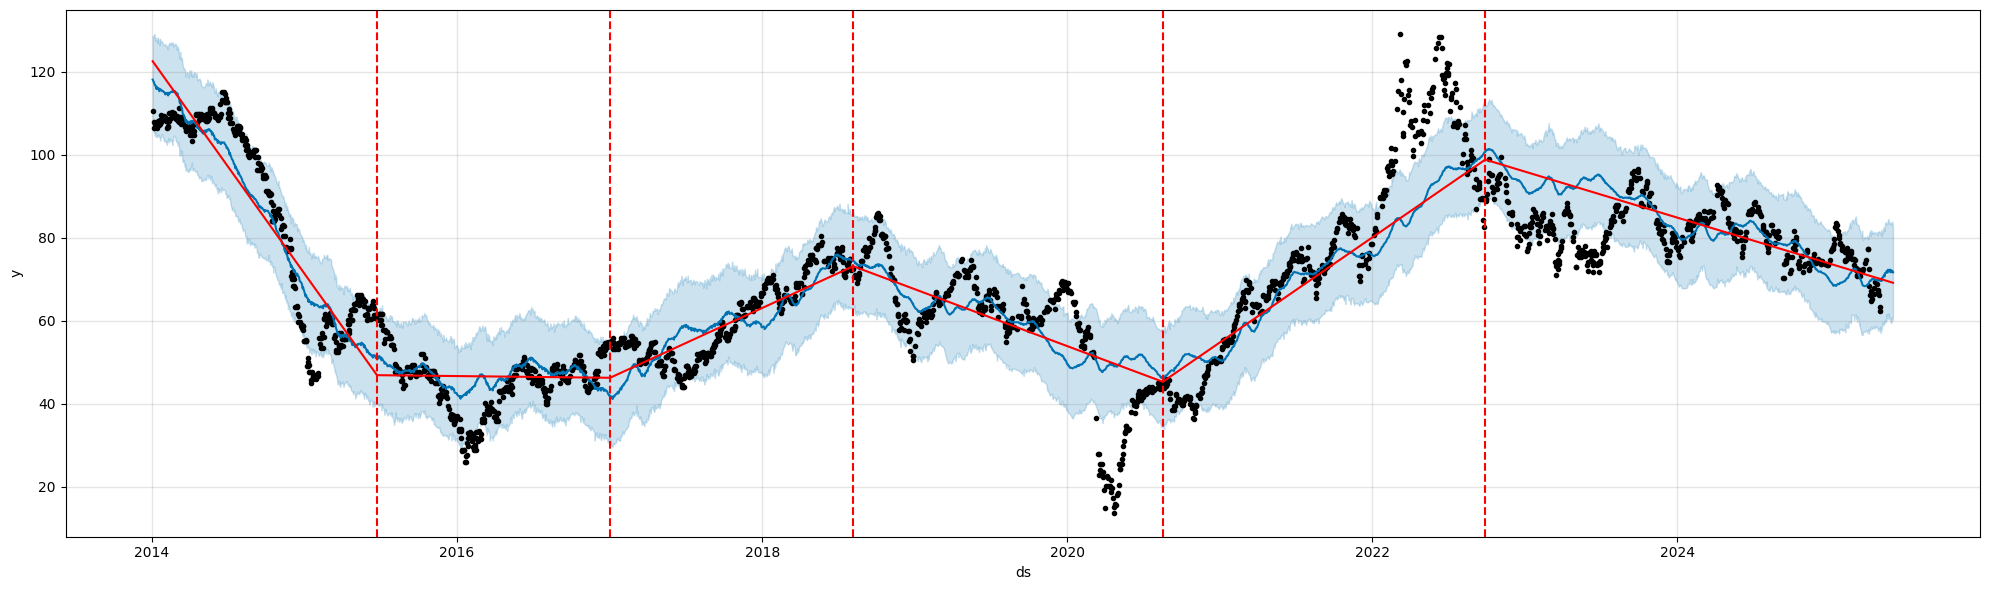

In [83]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

In [84]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 9.19%


**OBS: Olha como melhorou o nosso MAPE geral, quando comparado ao MAPE do ARIMA**

### Cross validation
Para validar o modelo Prophet, realizamos a **validação cruzada** com o objetivo de testar a precisão dos dados que o modelo **nunca viu antes**. Essa abordagem garante uma avaliação mais robusta e realista do desempenho do modelo preditivo.  

### Objetivo  
A validação cruzada mede o erro de previsão, selecionando pontos de corte específicos. Para cada ponto de corte, o modelo é ajustado utilizando apenas os dados até aquele ponto, evitando vazamento de informação.  

### Interpretação dos Resultados  
No resultado da validação cruzada, observamos os seguintes valores:  
- **yhat:** Previsão do modelo para o período.  
- **yhat_lower:** Limite inferior da previsão, considerando a incerteza.  
- **yhat_upper:** Limite superior da previsão, refletindo a margem de erro.  
- **Ponto de Corte:** Momento a partir do qual a previsão é feita.  

A partir desses resultados, conseguimos medir a precisão do modelo e identificar possíveis desvios, ajustando os parâmetros conforme necessário para obter previsões mais consistentes.  

In [85]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 17 forecasts with cutoffs between 2016-06-12 00:00:00 and 2024-05-01 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/j98jpwx0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/fhpg68sw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60570', 'data', 'file=/tmp/tmpiw9vtasu/j98jpwx0.json', 'init=/tmp/tmpiw9vtasu/fhpg68sw.json', 'output', 'file=/tmp/tmpiw9vtasu/prophet_model1_i7ugdm/prophet_model-20250513025221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:52:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:52:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/00t1a8cz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/850juc90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [86]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-06-14,50.587081,48.120467,53.119537,47.88,2016-06-12
1,2016-06-16,50.825529,48.386484,53.245298,49.36,2016-06-12
2,2016-06-18,51.183955,48.765173,53.652967,47.47,2016-06-12
3,2016-06-20,51.542907,49.093074,53.820581,46.57,2016-06-12
4,2016-06-21,51.767426,49.324644,54.148763,48.18,2016-06-12


In [87]:
df_cv['cutoff'].unique()

<DatetimeArray>
['2016-06-12 00:00:00', '2016-12-09 00:00:00', '2017-06-07 00:00:00',
 '2017-12-04 00:00:00', '2018-06-02 00:00:00', '2018-11-29 00:00:00',
 '2019-05-28 00:00:00', '2019-11-24 00:00:00', '2020-05-22 00:00:00',
 '2020-11-18 00:00:00', '2021-05-17 00:00:00', '2021-11-13 00:00:00',
 '2022-05-12 00:00:00', '2022-11-08 00:00:00', '2023-05-07 00:00:00',
 '2023-11-03 00:00:00', '2024-05-01 00:00:00']
Length: 17, dtype: datetime64[ns]

In [88]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,227.150349,15.071508,12.227504,0.189247,0.149949,0.188213,0.215361
1,37 days,234.294822,15.306692,12.414892,0.191426,0.152414,0.190091,0.216867
2,38 days,241.902870,15.553227,12.561274,0.192722,0.153699,0.191509,0.216867
3,39 days,244.427420,15.634175,12.591797,0.192550,0.153699,0.191521,0.219449
4,40 days,248.359482,15.759425,12.663843,0.192662,0.148651,0.191522,0.227410
...,...,...,...,...,...,...,...,...
325,361 days,1267.411531,35.600724,28.510125,0.472995,0.324287,0.427631,0.549699
326,362 days,1268.352754,35.613940,28.486921,0.468749,0.315337,0.426149,0.551205
327,363 days,1288.885862,35.901057,28.774883,0.468686,0.323721,0.428798,0.549699
328,364 days,1324.958778,36.399983,29.279209,0.474257,0.327727,0.435863,0.542169


## Testando com um modelo Robusto (Prophet) - Com menos anos

### Criando e Ajustando um novo dataset para o Prophet

In [89]:
# Vou puxar os dados de 2023 em diante
dados_resumidos = df[df.index >= '2023-01-01']

In [ ]:
dados_resumidos.head()

,preco
data,
2025-05-02,61.57
2025-05-01,62.37
2025-04-30,63.37
2025-04-29,64.04
2025-04-28,66.13


In [90]:
dados_resumidos.tail()

,preco
data,
2023-01-06,76.41
2023-01-05,76.73
2023-01-04,75.31
2023-01-03,80.36
2023-01-02,82.82


In [91]:
# Use a função download para obter os dados
df = dados_resumidos.copy()
df['ds'] = df.index
df['y'] = df['preco']
df = df[['ds', 'y']].reset_index(drop=True)
df.head()

,ds,y
0,2025-05-02,61.57
1,2025-05-01,62.37
2,2025-04-30,63.37
3,2025-04-29,64.04
4,2025-04-28,66.13


### Separando os dados em treino e teste

In [92]:
train_data = df.sample(frac=0.7, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (412, 2)
testing data size : (177, 2)


### Criando e plotando o modelo preditivo

In [93]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/hgqok8j1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiw9vtasu/dc0i6z0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78865', 'data', 'file=/tmp/tmpiw9vtasu/hgqok8j1.json', 'init=/tmp/tmpiw9vtasu/dc0i6z0p.json', 'output', 'file=/tmp/tmpiw9vtasu/prophet_model680hc3hc/prophet_model-20250513025330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:53:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:53:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-02,81.970461,72.285134,81.451137,81.970461,81.970461,-5.200802,-5.200802,-5.200802,-2.850666,...,0.471054,0.471054,0.471054,-2.821191,-2.821191,-2.821191,0.0,0.0,0.0,76.769659
1,2023-01-03,81.975756,72.667918,82.070077,81.975756,81.975756,-4.538302,-4.538302,-4.538302,-2.850666,...,0.731536,0.731536,0.731536,-2.419172,-2.419172,-2.419172,0.0,0.0,0.0,77.437455
2,2023-01-04,81.981052,72.815888,81.999710,81.981052,81.981052,-4.534050,-4.534050,-4.534050,-2.850666,...,0.302675,0.302675,0.302675,-1.986059,-1.986059,-1.986059,0.0,0.0,0.0,77.447003
3,2023-01-05,81.986348,73.244047,82.692681,81.986348,81.986348,-4.038543,-4.038543,-4.038543,-2.850666,...,0.338750,0.338750,0.338750,-1.526628,-1.526628,-1.526628,0.0,0.0,0.0,77.947805
4,2023-01-06,81.991644,73.149111,82.847463,81.991644,81.991644,-3.831768,-3.831768,-3.831768,-2.850666,...,0.065256,0.065256,0.065256,-1.046358,-1.046358,-1.046358,0.0,0.0,0.0,78.159876


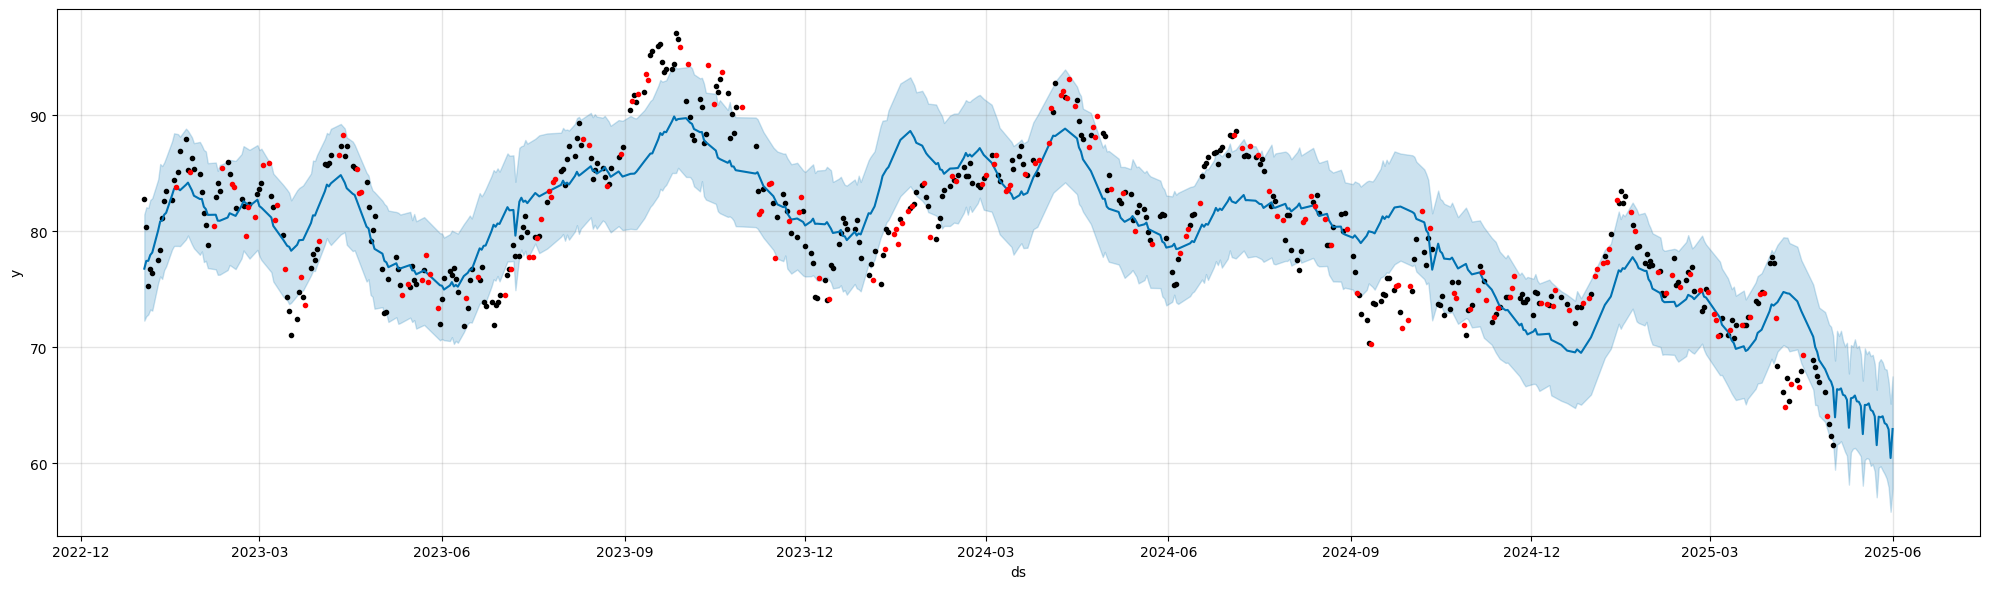

In [94]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

### Plotando com ploty

In [95]:
import plotly.graph_objects as go

# Criar uma figura para o gráfico
fig = go.Figure()

# Adicionar a série temporal prevista ao gráfico
fig.add_trace(go.Scatter(x=previsao['ds'], y=previsao['yhat'], mode='lines', name='Previsão'))

# Adicionar os pontos de teste ao gráfico
fig.add_trace(go.Scatter(x=test_data['ds'], y=test_data['y'], mode='markers', marker=dict(color='red'), name='Dados de Teste'))

# Layout do gráfico
fig.update_layout(title='Previsão do Modelo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  showlegend=True,
                  xaxis=dict(rangeslider=dict(visible=True), type='date'))

# Exibir o gráfico
fig.show()

### Decompondo os dados:

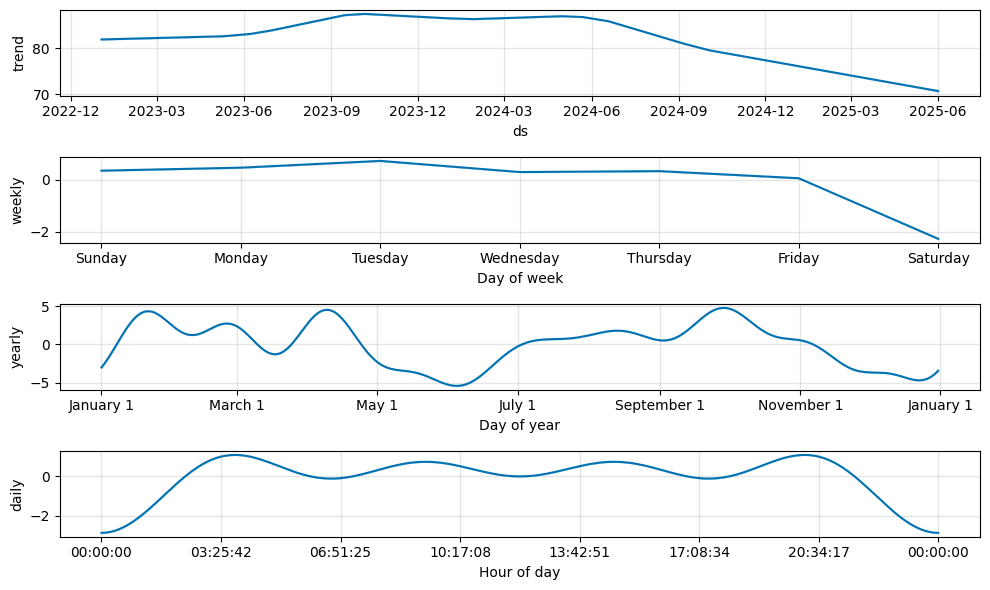

In [96]:
modelo.plot_components(previsao, figsize=(10,6));

In [97]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 3.71%


## Tabela final com os valores de previsão dos próximos 30 dias, com PROPHET

### Analisando os Resultados  
No primeiro teste realizado com o modelo **Prophet**, utilizando toda a base de dados desde **2014**, obtivemos um **MAPE de 15%**, que já representou uma melhora significativa em relação ao modelo ARIMA, cujo MAPE foi de **66%**.  

Porém, ao analisar o comportamento do preço do petróleo ao longo dos anos, percebi que ele sofreu **mudanças radicais**, com picos muito elevados e quedas bruscas devido a eventos geopolíticos. Essa alta volatilidade dificultou a modelagem preditiva, pois o preço pode tanto disparar quanto despencar de forma imprevisível.  

Diante disso, resolvi realizar um segundo teste com o Prophet, desta vez utilizando uma base de dados **mais recente**, a partir de **2023**. Ao encurtar a série temporal, conseguimos eliminar os picos extremos de preço que ocorreram nos últimos anos.  

### Resultado do Segundo Modelo  
Com essa abordagem mais específica, o modelo Prophet apresentou um desempenho muito melhor, obtendo um **MAPE de 3,08%**. Isso mostra que, ao focar em um período mais homogêneo e recente, o modelo conseguiu capturar melhor as variações atuais do preço do petróleo.  

Esses resultados indicam que, para séries temporais com mudanças estruturais significativas ao longo do tempo, utilizar períodos mais recentes pode resultar em previsões mais precisas.  

In [98]:
import pandas as pd

# Gerar datas para os próximos 90 dias
data_futuro = pd.date_range(start=df['ds'].max(), periods=30, freq='D')[1:]
data_futuro = pd.DataFrame(data_futuro, columns=['ds'])

# Fazer previsões para os próximos 90 dias
previsao_futuro = modelo.predict(data_futuro)

# Selecionar as colunas relevantes
tabela_previsao = previsao_futuro[['ds', 'yhat']].rename(columns={'yhat': 'previsao'})

# Exibir a tabela
print(tabela_previsao)

           ds   previsao
0  2025-05-03  63.948295
1  2025-05-04  66.376529
2  2025-05-05  66.323914
3  2025-05-06  66.440887
4  2025-05-07  65.889388
5  2025-05-08  65.820422
6  2025-05-09  65.456001
7  2025-05-10  63.044743
8  2025-05-11  65.593239
9  2025-05-12  65.638002
10 2025-05-13  65.828745
11 2025-05-14  65.327390
12 2025-05-15  65.285610
13 2025-05-16  64.926724
14 2025-05-17  62.501239
15 2025-05-18  65.018140
16 2025-05-19  65.016767
17 2025-05-20  65.149997
18 2025-05-21  64.583153
19 2025-05-22  64.471451
20 2025-05-23  64.041795
21 2025-05-24  61.548216
22 2025-05-25  64.003077
23 2025-05-26  63.948857
24 2025-05-27  64.041258
25 2025-05-28  63.448048
26 2025-05-29  63.326456
27 2025-05-30  62.904919
28 2025-05-31  60.438499
